# Subtracting Galactic Signal

pygdsm requires installation from source code here: https://github.com/telegraphic/pygdsm.

The best machine to do this runs Unix Operating system. Installation on Windows requires WSL (windows subsystem linux).

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pygdsm
import healpy as hp
import pathlib

# healpy variables
n_side = 256
n_pix = hp.nside2npix(n_side)
# Solid angle of each pixel
omega = hp.nside2pixarea(n_side)  # in steradians

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import EarthLocation, AltAz, SkyCoord

# Adak Island location
test_site_latitude = 51.8
test_site_longitude = -176.6
test_site_elevation_meters = 5 # meters

test_site_location = EarthLocation(
    lat=test_site_latitude * u.deg,
    lon=test_site_longitude * u.deg,
    height=test_site_elevation_meters * u.m
)

In [8]:
import sys
sys.path.append('/home/peterson_lab/Highz-EXP/src')

In [9]:
# Load custom modules
from highz_exp.file_load import DSFileLoader

In [10]:
# File paths in a python environment hosted in WSL Ubuntu
data_folder = pathlib.Path("/mnt/c/Users/Peterson Lab/Documents/highz2026/Adak_compressed/20251223") # update with your own path
antenna_response_file = pathlib.Path("/mnt/c/Users/Peterson Lab/Documents/highz2026/Antenna_S11/Adak/Ant3_far.s1p") # update

In [11]:
# load spectral data for antenna 
state_list = ["antenna", "open_circuit", "short_circuit", "long_cable", "blackbody", "resistor", "noise_diode"]

loader = DSFileLoader(data_folder)

antenna_timestamps, antenna_spectra = loader.load(0, False)  # state no: 0-antenna, 1-open, 2-short, 4-blackbody, 5-resistor, 6-noise diode

### Simulated Galactic Signal

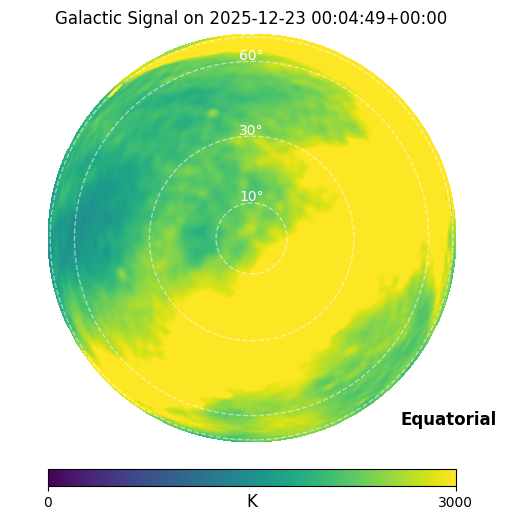

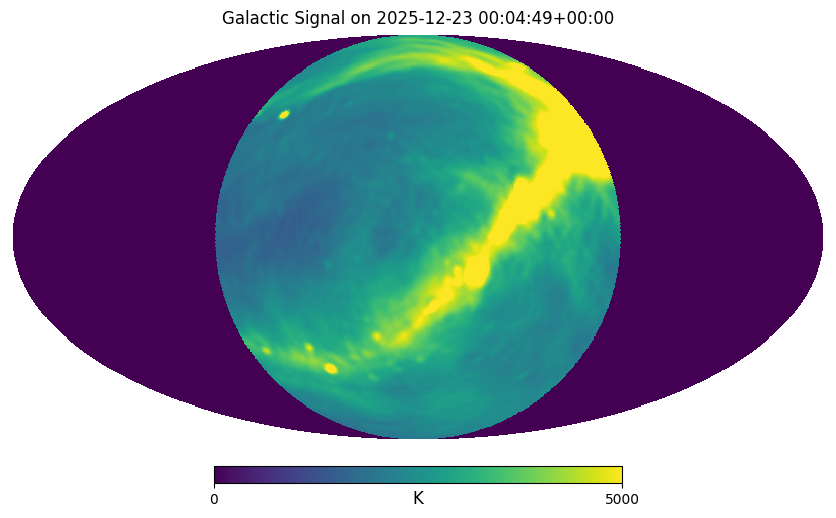

In [24]:
def generate_healpix_map(frequency_mhz, utc_timestamp, observer='LFSM'):
    """
    this will generate the galactic image for the specified frequency, time, and location
    specifying the lat and lon will automatically transform the image from galactic coordinates
    to equatorial coordinates and center on the zenith (straight up)

    the "top" of the of the healpix map is the zenith (straight up)

    Parameters
    ----------
    frequency_mhz : float
        frequency in MHz
    utc_timestamp : datetime.datetime object
        UTC timestamp as a datetime object (e.g., datetime.datetime(2023, 1, 1, 12, 0, 0))
    observer: str
        Options: '08', '16', 'LFSM', 'Haslam'
    """
    if observer == '08':
        ov = pygdsm.GSMObserver08()
    elif observer == '16':
        ov = pygdsm.GSMObserver16()
    elif observer == 'Haslam':
        ov = pygdsm.HaslamObserver()
    elif observer == 'LFSM':
        ov = pygdsm.LFSMObserver()
    else:
        raise ValueError("Invalid observer type. Choose from '08', '16', 'LFSM', 'Haslam'.")
    ov.lon = test_site_longitude
    ov.lat = test_site_latitude
    ov.elev = test_site_elevation_meters
    ov.date = utc_timestamp

    hmap = ov.generate(frequency_mhz)
    hmap = np.ma.filled(hmap,fill_value=0)
    return hmap

def visualize_hmap(hmap, title="Example Galactic Healpix Map"):
    """
    Visualize the healpix map with azimuth and zenith angle labels.

    Parameters
    ----------
    hmap : array
        Healpix map data.
    """
        
    hp.orthview(hmap, half_sky=True, min=0, max=3000, coord='C', title=title, unit="K")

    # Now add custom labels for azimuth and zenith angle
    ax = plt.gca()

    # Add concentric zenith angle circles (like elevation rings)
    zenith_angles = [10, 30, 60, 80]
    for za in zenith_angles:
        circle = plt.Circle((0, 0), np.sin(np.radians(za)), color='white', ls='--', fill=False, alpha=0.5)
        ax.add_artist(circle)
        plt.text(0, np.sin(np.radians(za)) + 0.01, f"{za}°", color='white', ha='center')

    # Add azimuth angle labels
    az_labels = [0, 90, 180, 270]
    label_pos = {
        0: (0, 1.05),       # North (up)
        90: (1.05, 0),      # East (right)
        180: (0, -1.1),     # South (down)
        270: (-1.1, 0),     # West (left)
    }
    for az in az_labels:
        x, y = label_pos[az]
        plt.text(x, y, f"{az}°", color='white', ha='center', va='center')

    plt.show()
    

# Visualization (use Gnomonic for observer-centered view)
hmap = generate_healpix_map(70, antenna_timestamps[0])

visualize_hmap(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}")
hp.mollview(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}", unit="K", max=5000)

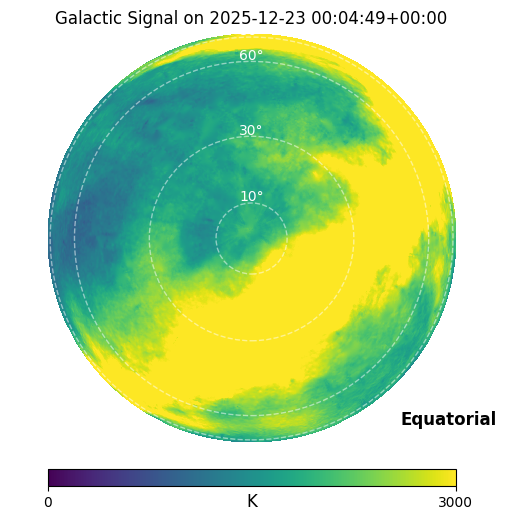

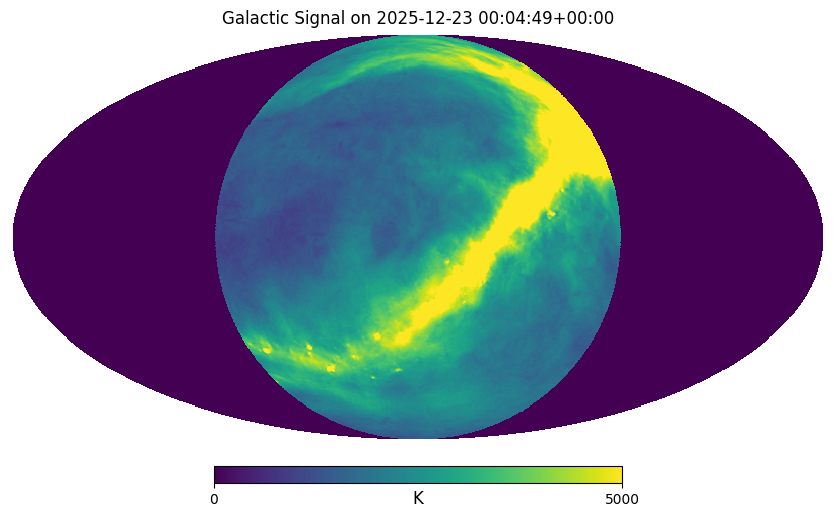

In [23]:
# Compare with Haslam map
hmap = generate_healpix_map(70, antenna_timestamps[0], observer='Haslam')

visualize_hmap(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}")
hp.mollview(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}", unit="K", max=5000)

### Load the beam pattern (effective heights)

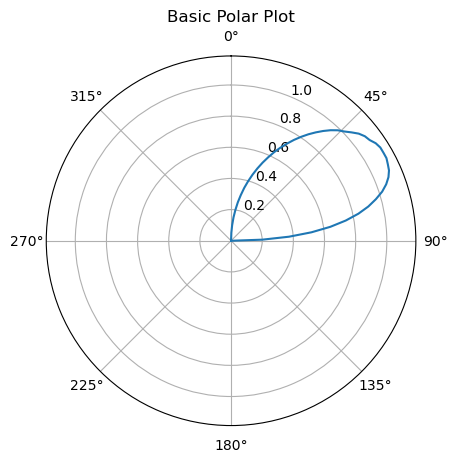

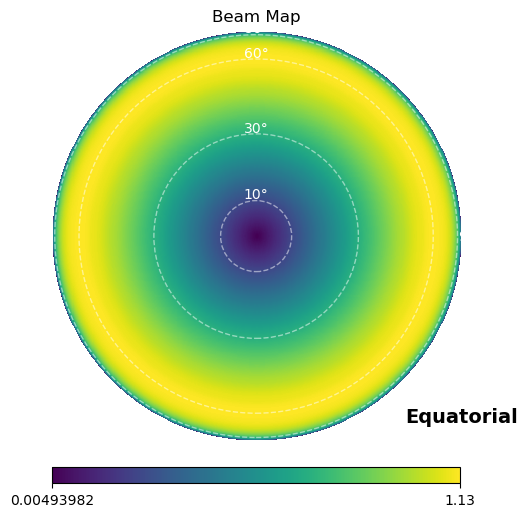

In [ ]:

import numpy as np
import healpy as hp
from scipy.interpolate import RegularGridInterpolator

gain_info = np.loadtxt("mimi_c49_antenna_gain.csv", delimiter=",", skiprows=2)
gain_freqs = np.arange(25, 250+25, 25)
gain_thetas = np.deg2rad(gain_info[:,0])
gain_phis = np.linspace(0, 2*np.pi, 181, endpoint=True)
gain_pattern = gain_info[:,1:].T # each row is a frequency, each column is a theta (elevation)


def load_effective_height(frequency_mhz):
    return gain_pattern[np.where(gain_freqs == frequency_mhz)[0]].repeat(181, axis=0).T

def generate_beam_map(frequency_mhz) -> np.ndarray:
    """
    Generate a beam map of the antenna for the given frequency using interpolation."""
    effective_height_2d_map = load_effective_height(frequency_mhz)
    num_theta, num_phi = effective_height_2d_map.shape
    theta1 = np.linspace(0, np.pi/2, num_theta)
    phi1 = np.linspace(0, 2*np.pi, num_phi)
    interpolator = RegularGridInterpolator(
        (theta1, phi1), effective_height_2d_map,
        bounds_error=False, fill_value=0
    )
    beam_map = np.full(n_pix, 0.0)  # initialize with UNSEEN for masking
    # Get pixel centers in (θ, φ)
    theta_hp, phi_hp = hp.pix2ang(n_side, np.arange(n_pix))
    # Find pixels in upper hemisphere (θ <= π/2)
    mask_upper = theta_hp <= (np.pi / 2)
    # Prepare interpolation points only for those pixels
    interp_points = np.vstack((theta_hp[mask_upper], phi_hp[mask_upper])).T
    # Interpolate
    interp_values = interpolator(interp_points)
    # Assign to map (fill rest with UNSEEN or 0)
    beam_map[mask_upper] = interp_values
    rot = hp.Rotator([0, 90, 0])
    beam_map = rot.rotate_map_pixel(beam_map)
    return beam_map

effective_height_2d_map = load_effective_height(100)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set 0° at top, clockwise
ax.set_theta_zero_location('N')  # 0 degrees = North (top)
ax.set_theta_direction(-1)       # Clockwise direction
ax.plot(gain_thetas, effective_height_2d_map[:,0])

plt.title("Basic Polar Plot")
plt.show()

interpolator = RegularGridInterpolator(
    (gain_thetas, gain_phis), effective_height_2d_map,
    bounds_error=False, fill_value=0
)

beam_map = np.full(n_pix, 0.0)  # initialize with UNSEEN for masking

# Get pixel centers in (θ, φ)
theta_hp, phi_hp = hp.pix2ang(n_side, np.arange(n_pix))

# Find pixels in upper hemisphere (θ <= π/2)
mask_upper = theta_hp <= (np.pi / 2)

# Prepare interpolation points only for those pixels
interp_points = np.vstack((theta_hp[mask_upper], phi_hp[mask_upper])).T

# Interpolate
interp_values = interpolator(interp_points)

# Assign to map (fill rest with UNSEEN or 0)
beam_map[mask_upper] = interp_values

rot = hp.Rotator([0, 90, 0])
#theta, phi = rot(theta, phi)
beam_map = rot.rotate_map_pixel(beam_map)
hp.orthview(beam_map, half_sky=True, coord='C', title="Beam Map")
# Now add custom labels for azimuth and zenith angle
ax = plt.gca()

# Add concentric zenith angle circles (like elevation rings)
zenith_angles = [10, 30, 60, 80]
for za in zenith_angles:
    circle = plt.Circle((0, 0), np.sin(np.radians(za)), color='white', ls='--', fill=False, alpha=0.5)
    ax.add_artist(circle)
    plt.text(0, np.sin(np.radians(za)) + 0.01, f"{za}°", color='white', ha='center')

# Add azimuth angle labels
az_labels = [0, 90, 180, 270]
label_pos = {
    0: (0, 1.05),       # North (up)
    90: (1.05, 0),      # East (right)
    180: (0, -1.1),     # South (down)
    270: (-1.1, 0),     # West (left)
}
for az in az_labels:
    x, y = label_pos[az]
    plt.text(x, y, f"{az}°", color='white', ha='center', va='center')

plt.show()



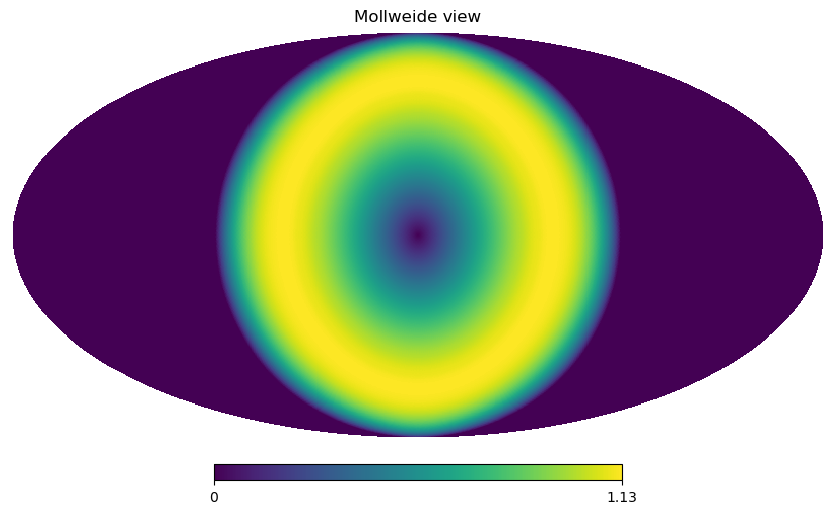

In [ ]:
hp.mollview(beam_map)

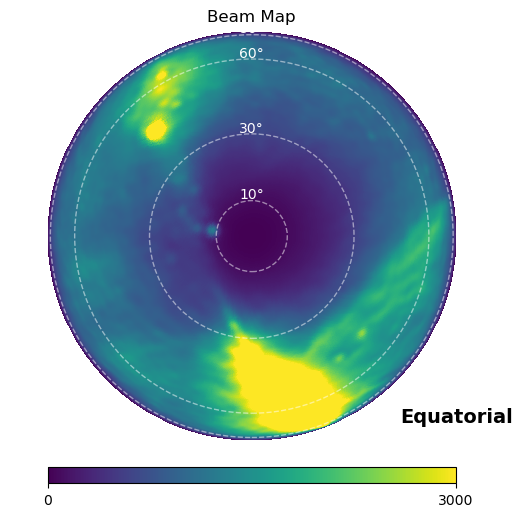

In [ ]:
integrand = hmap * beam_map ** 2
hp.orthview(integrand, half_sky=True, coord='C', title="Beam Map", min=0, max=3000)
# Now add custom labels for azimuth and zenith angle
ax = plt.gca()

# Add concentric zenith angle circles (like elevation rings)
zenith_angles = [10, 30, 60, 80]
for za in zenith_angles:
    circle = plt.Circle((0, 0), np.sin(np.radians(za)), color='white', ls='--', fill=False, alpha=0.5)
    ax.add_artist(circle)
    plt.text(0, np.sin(np.radians(za)) + 0.01, f"{za}°", color='white', ha='center')

# Add azimuth angle labels
az_labels = [0, 90, 180, 270]
label_pos = {
    0: (0, 1.05),       # North (up)
    90: (1.05, 0),      # East (right)
    180: (0, -1.1),     # South (down)
    270: (-1.1, 0),     # West (left)
}
for az in az_labels:
    x, y = label_pos[az]
    plt.text(x, y, f"{az}°", color='white', ha='center', va='center')

plt.show()


### Recall

$$
T_A(\nu) = \frac{ \int_{\Omega} T_b(\theta, \phi, \nu) \, B(\theta, \phi, \nu) \, d\Omega }{ \int_{\Omega} B(\theta, \phi, \nu) \, d\Omega }
$$

This is how we will simulate the galactic signal, as seen by our antenna. Then we would attempt to subtract the galactic foreground from our data.

In [ ]:
def create_simulated_waterfall(utc_timestamps, frequencies_mhz):
    """
    Create a simulated waterfall of antenna data based on healpix maps and beam patterns"""
    simulated_antenna_data = np.zeros((len(utc_timestamps), len(frequencies_mhz)))
    for j, freq in enumerate(frequencies_mhz):
        beam_map = generate_beam_map(int(freq))
        D = np.sum(beam_map**2) * omega
        for i, timestamp in enumerate(utc_timestamps):
            hmap = generate_healpix_map(freq, timestamp)
            N = np.sum(hmap * beam_map ** 2) * omega
            #N = np.sum(hmap * beam_map) * omega
            simulated_antenna_data[i, j] = N#/D
            print(freq, timestamp, N)#/D)
    return simulated_antenna_data


#simulated_antenna_data = create_simulated_waterfall(new_utc_timestamps, gain_freqs)


simulated_antenna_data = create_simulated_waterfall(list([new_utc_timestamps[0],]), gain_freqs)

25 2024-12-19 00:15:18 83528.03578747054
50 2024-12-19 00:15:18 19452.210844196274
75 2024-12-19 00:15:18 10350.669553947468
100 2024-12-19 00:15:18 7431.677559155423
125 2024-12-19 00:15:18 5259.667426992462
150 2024-12-19 00:15:18 2458.5331633355327
175 2024-12-19 00:15:18 912.9189475187482
200 2024-12-19 00:15:18 369.565156389155
225 2024-12-19 00:15:18 175.84671261275514
250 2024-12-19 00:15:18 97.77721141663466


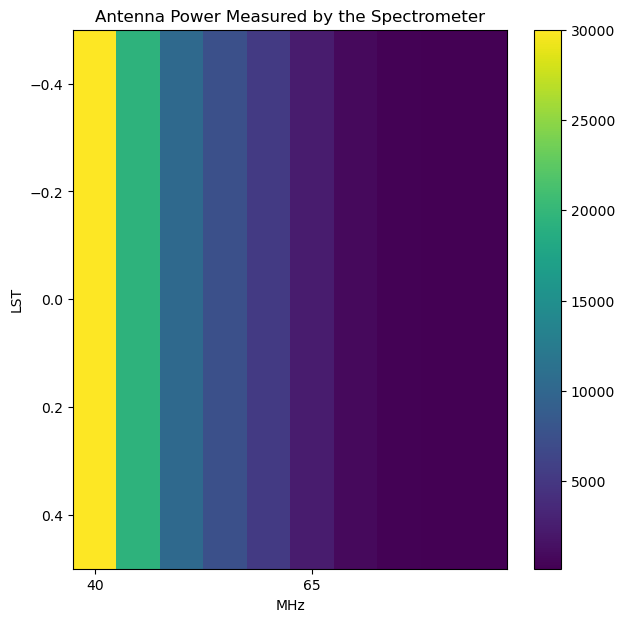

In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=np.arange(0,len(new_frequencies_mhz),5), labels=new_frequencies_mhz[::5])
plt.xlabel("MHz")
#plt.yticks(ticks=plot_timestamp_tick_idx, labels=plot_timestamp_tick_labels)
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(simulated_antenna_data, vmin=1.5e2, vmax=3e4, aspect="auto")
_ = plt.colorbar()

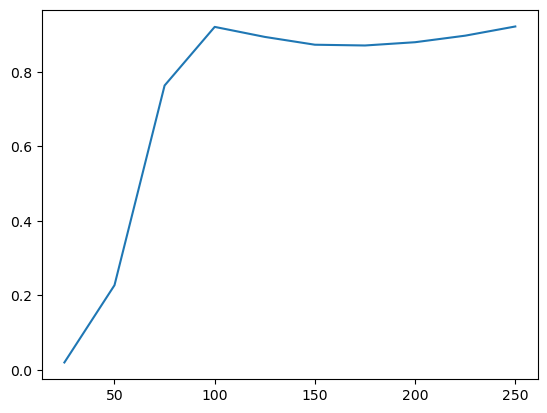

In [ ]:
import skrf as rf
import numpy as np

ntwk = rf.Network('antenna4.s1p')
s11 = ntwk.s[:, 0, 0]   # shape (N,)

z0 = ntwk.z0[0]         # typically 50 ohms
nwk_frequencies = ntwk.f
impedance = z0 * (1 + s11) / (1 - s11)
real_impedance = np.real(impedance)
mismatch_loss = 1 - np.abs(s11)**2    # scalar between 0 and 1

from scipy.interpolate import interp1d

# Create interpolator
f = interp1d(nwk_frequencies/1e6, mismatch_loss, kind='cubic')  # kind can also be 'cubic', 'nearest', etc.
f2 = interp1d(nwk_frequencies/1e6, real_impedance, kind='cubic')  # kind can also be 'cubic', 'nearest', etc.
# Interpolate
new_mismatch_loss = f(gain_freqs)
new_real_impedence = f2(gain_freqs)
plt.plot(gain_freqs, new_mismatch_loss)



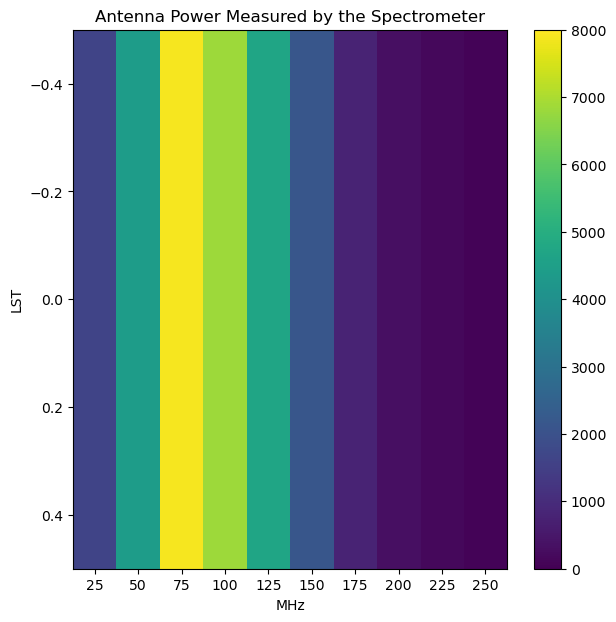

In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=np.arange(0,len(gain_freqs)), labels=gain_freqs)
plt.xlabel("MHz")
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(simulated_antenna_data*new_mismatch_loss, vmin=0, vmax=8e3, aspect="auto")
_ = plt.colorbar()

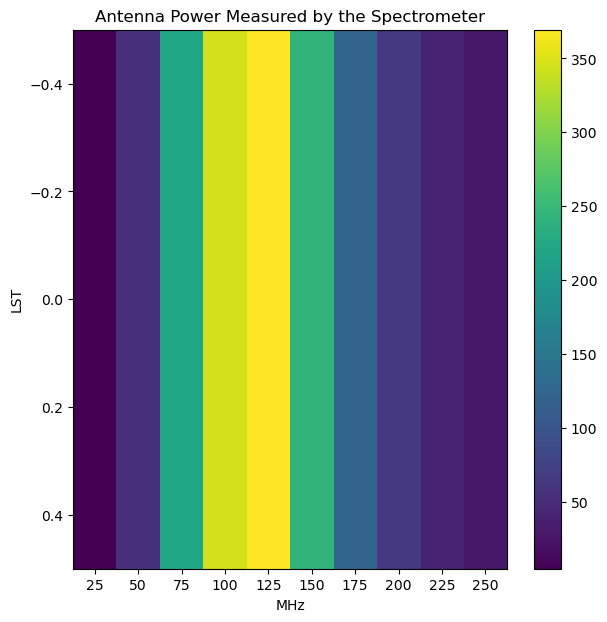

In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=np.arange(0,len(gain_freqs)), labels=gain_freqs)
plt.xlabel("MHz")
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(simulated_antenna_data*new_mismatch_loss * (gain_freqs*1e6)**2/c**2 *377/(50*4)*(.49)**2, aspect="auto")
_ = plt.colorbar()

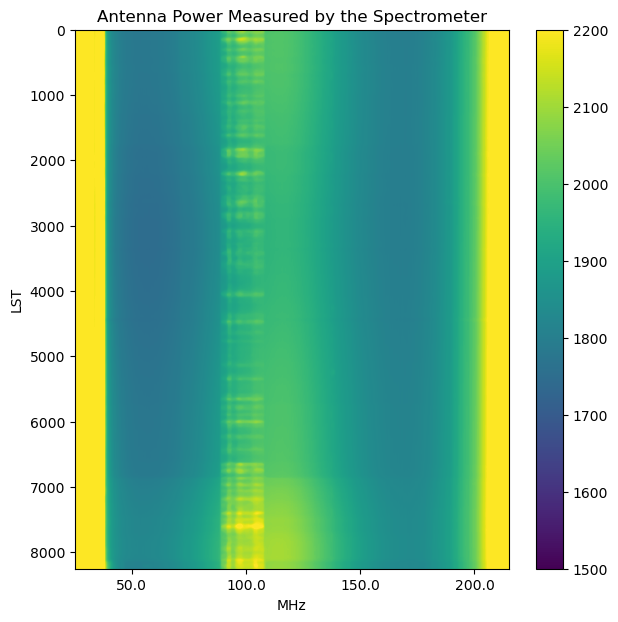

In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=plot_frequency_tick_idx, labels=plot_frequency_tick_labels)
plt.xlabel("MHz")
#plt.yticks(ticks=plot_timestamp_tick_idx, labels=plot_timestamp_tick_labels)
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(antenna_calibrated, vmin=1.5e3, vmax=2.2e3, aspect="auto")
_ = plt.colorbar()

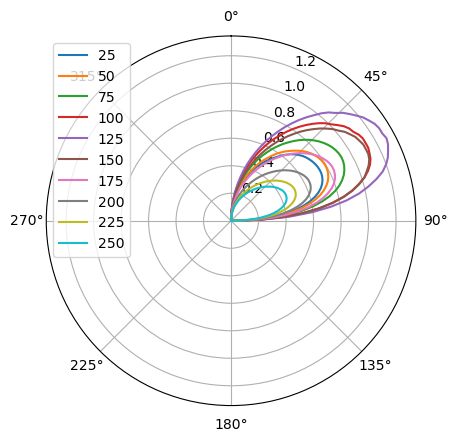

In [ ]:
gain_info = np.loadtxt("mimi_c49_antenna_gain.csv", delimiter=",", skiprows=2)
gain_freqs = np.arange(25, 250+25, 25)
gain_phis = np.deg2rad(gain_info[:,0])
gain_pattern = gain_info[:,1:].T
# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set 0° at top, clockwise
ax.set_theta_zero_location('N')  # 0 degrees = North (top)
ax.set_theta_direction(-1)       # Clockwise direction
for idx, beam in enumerate(gain_pattern):
    ax.plot(gain_phis, beam, label=gain_freqs[idx])

ax.legend()
plt.show()

TODO:
1. Obtain the real antenna effective areas of each antenna - stop using the FEKO effective height (we are too close to obtaining real spectra to continue relying on FEKO simulation done in 2021 or something like that).
2. Go somewhere where there's less noise (obviously) - go to the frozen Canadian lake.
3. Change the data format of the spectra - transition from csv (or whatever the hell we're working with now) to FITS.


Hopefully these things will eliminate the "shabby" pipeline we're currently operating with, align the peak of the spectra obtained by the telescope to the pygdsm data, and actually unveil the 21 cm neutral hydrogen line that we've been looking for for 5+ years.
